# Introduction au Deep Learning avec TensorFlow/Keras

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer les fondamentaux du deep learning à travers deux architectures essentielles :

1. **Les réseaux de neurones denses (Fully Connected Networks)** - L'architecture de base
2. **Les réseaux de neurones convolutifs (CNN)** - Spécialisés pour les images

Nous utiliserons le dataset **Fashion MNIST**, qui contient 70 000 images de vêtements en niveaux de gris (28×28 pixels) réparties en 10 catégories.

## Pourquoi Fashion MNIST ?

- Plus challengeant que MNIST classique (chiffres)
- Permet de bien visualiser les différences entre architectures
- Natif dans Keras, donc facile à charger
- Représentatif de problèmes réels de classification d'images

## 1. Imports et configuration

Commençons par importer toutes les bibliothèques nécessaires.

In [32]:
# Bibliothèques principales
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.callbacks import Callback

# Configuration GPU : activer la croissance dynamique de la mémoire
# Cela évite les erreurs de mémoire GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")
    print("Utilisation du CPU par défaut")

# Configuration pour des graphiques de qualité
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

GPU(s) détecté(s): 1 - Croissance mémoire activée
TensorFlow version: 2.20.0
Keras version: 3.11.3


## 2. Chargement et exploration des données

### 2.1 Chargement du dataset Fashion MNIST

Fashion MNIST contient :
- **60 000 images d'entraînement**
- **10 000 images de test**
- **10 classes** : T-shirt, Pantalon, Pull, Robe, Manteau, Sandale, Chemise, Basket, Sac, Bottine

In [33]:
# Chargement du dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Noms des classes
class_names = ['T-shirt/top', 'Pantalon', 'Pull', 'Robe', 'Manteau',
               'Sandale', 'Chemise', 'Basket', 'Sac', 'Bottine']

print(f"Forme des données d'entraînement: {X_train.shape}")
print(f"Forme des labels d'entraînement: {y_train.shape}")
print(f"Forme des données de test: {X_test.shape}")
print(f"Forme des labels de test: {y_test.shape}")
print(f"\nPlage des valeurs des pixels: [{X_train.min()}, {X_train.max()}]")

Forme des données d'entraînement: (60000, 28, 28)
Forme des labels d'entraînement: (60000,)
Forme des données de test: (10000, 28, 28)
Forme des labels de test: (10000,)

Plage des valeurs des pixels: [0, 255]


### 2.2 Visualisation des données

Visualisons quelques exemples pour comprendre à quoi ressemble notre dataset.

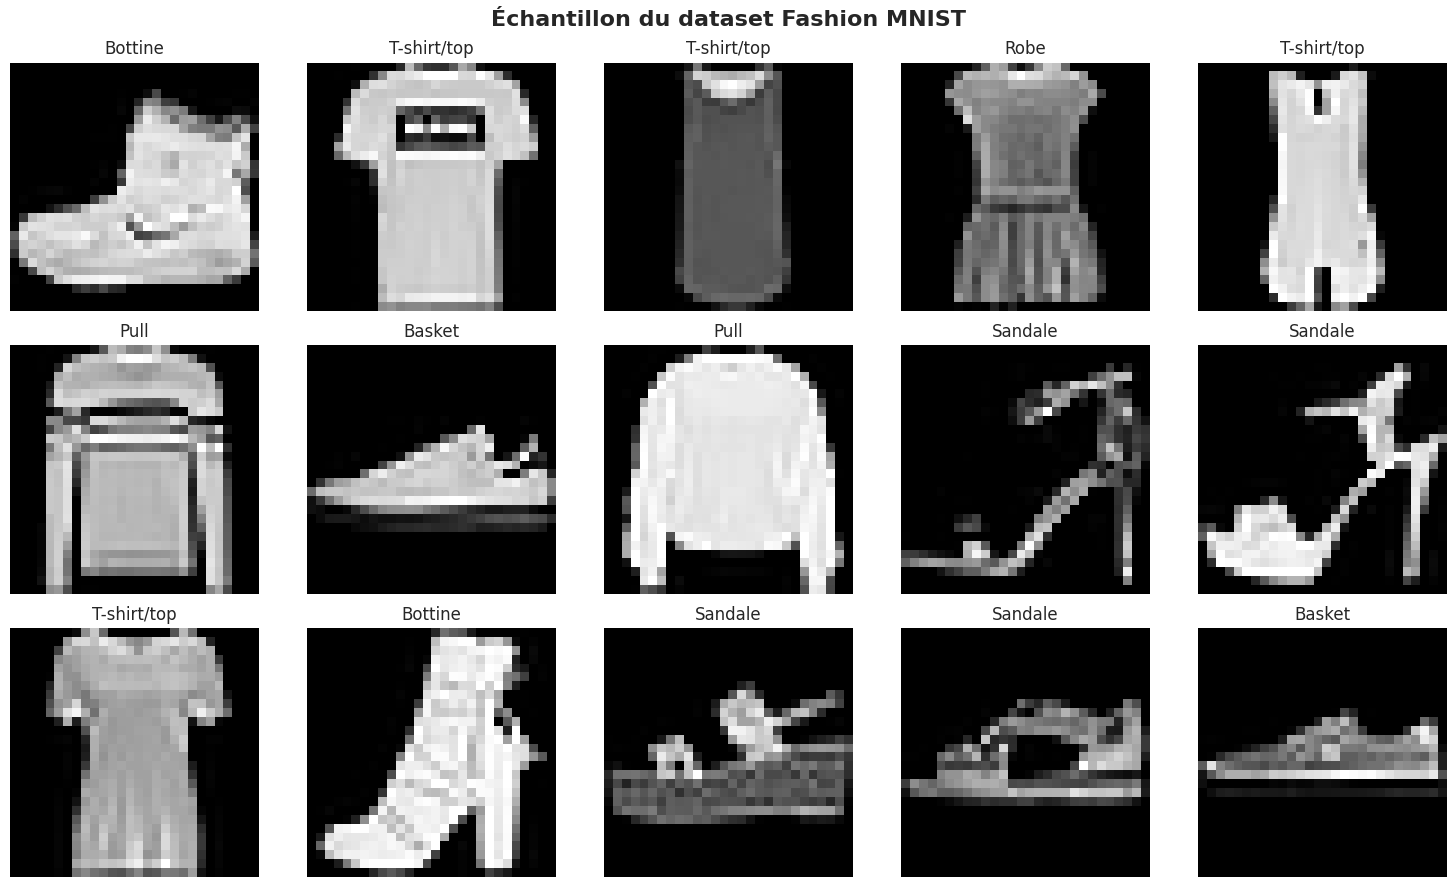

In [34]:
# Visualisation d'un échantillon d'images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Échantillon du dataset Fashion MNIST', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'{class_names[y_train[i]]}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 2.3 Distribution des classes

Vérifions que notre dataset est bien équilibré.

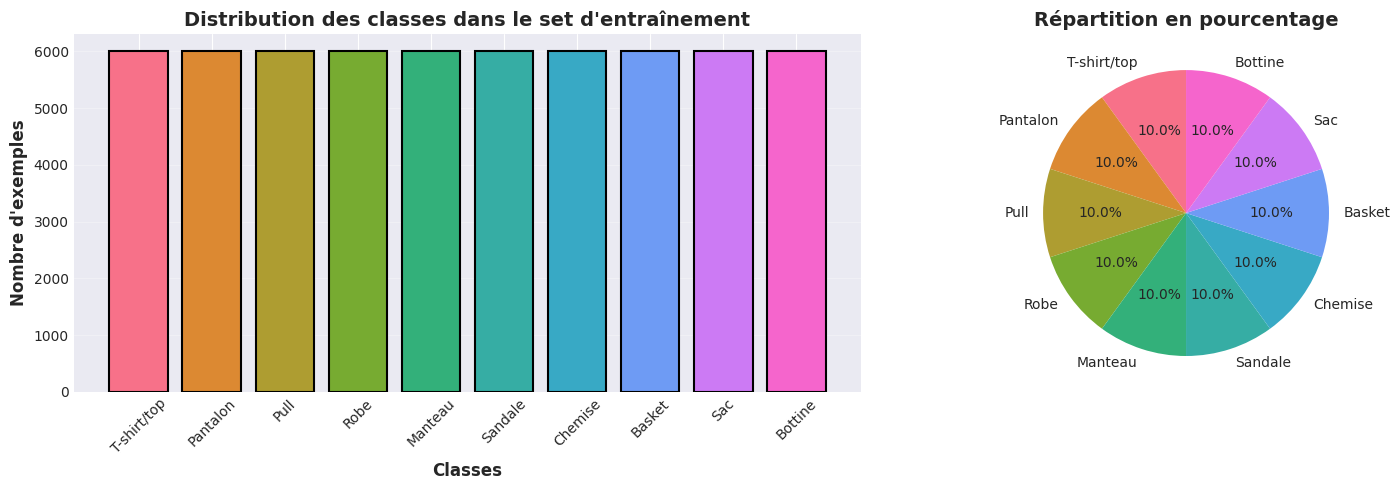

Le dataset est parfaitement équilibré : 6000 exemples par classe


In [35]:
# Analyse de la distribution des classes
unique, counts = np.unique(y_train, return_counts=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Graphique en barres
colors = sns.color_palette("husl", 10)
ax1.bar([class_names[i] for i in unique], counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nombre d\'exemples', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des classes dans le set d\'entraînement', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Camembert
ax2.pie(counts, labels=[class_names[i] for i in unique], autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 10})
ax2.set_title('Répartition en pourcentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Le dataset est parfaitement équilibré : 6000 exemples par classe")

### 2.4 Analyse statistique des images

Regardons la distribution des valeurs de pixels.

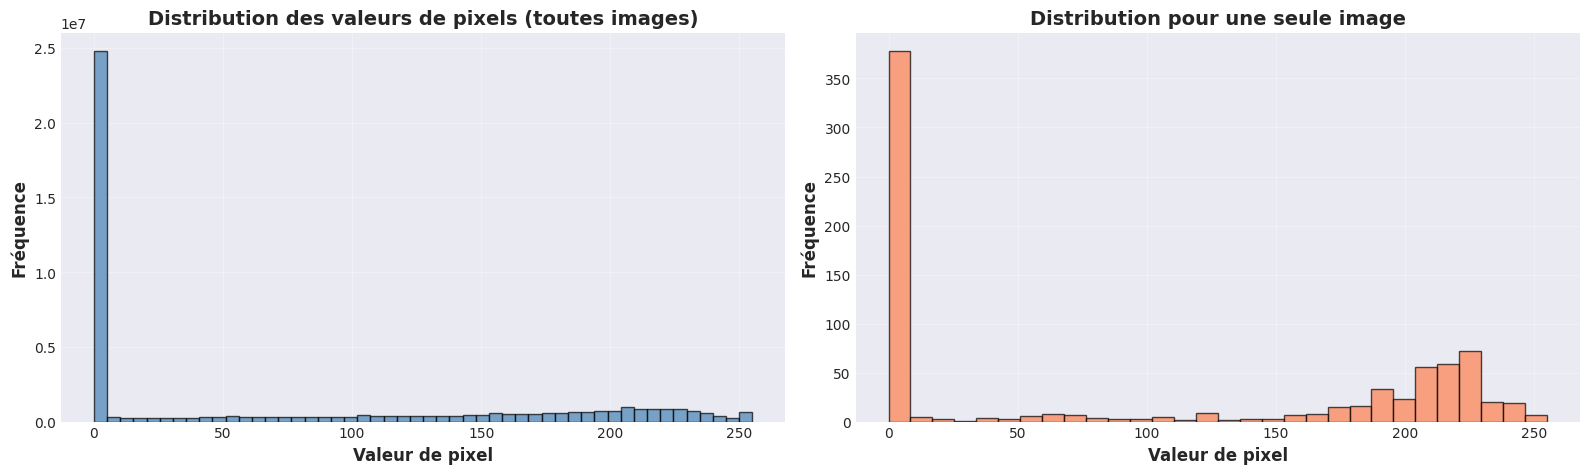

Moyenne des pixels: 72.94
Écart-type des pixels: 90.02


In [36]:
# Histogramme de la distribution des pixels
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribution globale
axes[0].hist(X_train.flatten(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Valeur de pixel', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Fréquence', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution des valeurs de pixels (toutes images)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Distribution pour une image spécifique
axes[1].hist(X_train[0].flatten(), bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Valeur de pixel', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Fréquence', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution pour une seule image', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Moyenne des pixels: {X_train.mean():.2f}")
print(f"Écart-type des pixels: {X_train.std():.2f}")

## 3. Préparation des données

### 3.1 Normalisation

**Pourquoi normaliser ?**
- Les réseaux de neurones fonctionnent mieux avec des valeurs entre 0 et 1
- Cela accélère la convergence de l'entraînement
- Évite les problèmes de gradient explosif ou disparaissant

In [37]:
# Normalisation des pixels de [0, 255] vers [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

print(f"Nouvelles valeurs - Min: {X_train_normalized.min()}, Max: {X_train_normalized.max()}")
print(f"Moyenne après normalisation: {X_train_normalized.mean():.4f}")

Nouvelles valeurs - Min: 0.0, Max: 1.0
Moyenne après normalisation: 0.2860


### 3.2 Préparation des labels

Nous allons créer deux versions des labels :
- **Labels entiers** : pour les modèles avec `sparse_categorical_crossentropy`
- **Labels one-hot encodés** : pour les modèles avec `categorical_crossentropy`

**One-hot encoding** : Transformer `3` en `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`

In [38]:
# One-hot encoding des labels
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

print(f"Label original: {y_train[0]}")
print(f"Label one-hot encodé: {y_train_categorical[0]}")
print(f"\nForme des labels catégoriels: {y_train_categorical.shape}")

Label original: 9
Label one-hot encodé: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Forme des labels catégoriels: (60000, 10)


### 3.3 Création d'un set de validation

**Pourquoi un set de validation ?**
- Permet de monitorer le surapprentissage (overfitting) en temps réel
- Sert à ajuster les hyperparamètres
- Le set de test reste "intact" pour l'évaluation finale

In [39]:
# Séparation : 50000 train / 10000 validation
X_val = X_train_normalized[50000:]
y_val = y_train_categorical[50000:]

X_train_final = X_train_normalized[:50000]
y_train_final = y_train_categorical[:50000]

print(f"Données d'entraînement: {X_train_final.shape[0]} exemples")
print(f"Données de validation: {X_val.shape[0]} exemples")
print(f"Données de test: {X_test_normalized.shape[0]} exemples")

Données d'entraînement: 50000 exemples
Données de validation: 10000 exemples
Données de test: 10000 exemples


## 4. Callback personnalisé pour la visualisation en temps réel

Créons un callback qui va afficher les métriques d'entraînement après chaque epoch.

**Qu'est-ce qu'un Callback ?**
- Une fonction qui s'exécute à des moments précis de l'entraînement
- Permet de monitorer, visualiser ou modifier le comportement du modèle
- Très utile pour le debugging et l'analyse

In [40]:
class LivePlotCallback(Callback):
    """
    Callback personnalisé pour visualiser les métriques en temps réel pendant l'entraînement.
    """
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.loss = []
        self.val_loss = []
        self.accuracy = []
        self.val_accuracy = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Enregistrement des métriques
        self.epochs.append(epoch + 1)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        
        # Effacement et redessin
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Graphique de la loss
        ax1.plot(self.epochs, self.loss, 'o-', label='Loss d\'entraînement', 
                linewidth=2, markersize=8, color='#2E86AB')
        ax1.plot(self.epochs, self.val_loss, 's-', label='Loss de validation', 
                linewidth=2, markersize=8, color='#A23B72')
        ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax1.set_title('Évolution de la Loss', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(alpha=0.3)
        
        # Graphique de l'accuracy
        ax2.plot(self.epochs, self.accuracy, 'o-', label='Accuracy d\'entraînement', 
                linewidth=2, markersize=8, color='#2E86AB')
        ax2.plot(self.epochs, self.val_accuracy, 's-', label='Accuracy de validation', 
                linewidth=2, markersize=8, color='#A23B72')
        ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax2.set_title('Évolution de l\'Accuracy', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(alpha=0.3)
        ax2.set_ylim([0, 1])
        
        plt.tight_layout()
        plt.show()
        
        # Affichage textuel
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
        print(f"Loss: {logs.get('loss'):.4f} - Accuracy: {logs.get('accuracy'):.4f}")
        print(f"Val Loss: {logs.get('val_loss'):.4f} - Val Accuracy: {logs.get('val_accuracy'):.4f}")

---

# PARTIE 1 : RÉSEAUX DE NEURONES DENSES (MLP)

## 5. Architecture des réseaux denses

### Qu'est-ce qu'un réseau dense ?

Un réseau de neurones dense (ou fully connected) est l'architecture la plus simple :
- **Chaque neurone** d'une couche est connecté à **tous les neurones** de la couche suivante
- Les images doivent être **aplaties** en vecteur 1D (28×28 = 784 pixels)
- Perte de l'information spatiale (position relative des pixels)

### Architecture que nous allons construire :

```
Input (784)  →  Dense(512) + ReLU  →  Dropout(0.3)  →  Dense(256) + ReLU  →  Dropout(0.3)  →  Dense(10) + Softmax
```

**Explication des composants :**
- **Dense(512)** : Couche de 512 neurones entièrement connectés
- **ReLU** : Fonction d'activation (Rectified Linear Unit) : f(x) = max(0, x)
- **Dropout(0.3)** : Désactive aléatoirement 30% des neurones pour éviter le surapprentissage
- **Softmax** : Fonction d'activation finale qui produit des probabilités (somme = 1)

In [41]:
# Préparation des données pour le réseau dense (aplatir les images)
X_train_flat = X_train_final.reshape(-1, 28 * 28)
X_val_flat = X_val.reshape(-1, 28 * 28)
X_test_flat = X_test_normalized.reshape(-1, 28 * 28)

print(f"Forme après aplatissement: {X_train_flat.shape}")
print(f"Chaque image est maintenant un vecteur de {28*28} valeurs")

Forme après aplatissement: (50000, 784)
Chaque image est maintenant un vecteur de 784 valeurs


### 5.1 Construction du modèle dense

In [42]:
def create_dense_model():
    """
    Crée un réseau de neurones dense à 3 couches.
    """
    model = keras.Sequential([
        # Couche d'entrée implicite (784 inputs)
        
        # Première couche cachée : 512 neurones
        layers.Dense(512, activation='relu', input_shape=(784,), name='dense_1'),
        layers.Dropout(0.3, name='dropout_1'),
        
        # Deuxième couche cachée : 256 neurones
        layers.Dense(256, activation='relu', name='dense_2'),
        layers.Dropout(0.3, name='dropout_2'),
        
        # Couche de sortie : 10 neurones (1 par classe)
        layers.Dense(10, activation='softmax', name='output')
    ])
    
    return model

# Création du modèle
dense_model = create_dense_model()

# Affichage de l'architecture
dense_model.summary()

/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

### 5.2 Visualisation de l'architecture

Regardons en détail le nombre de paramètres de chaque couche.

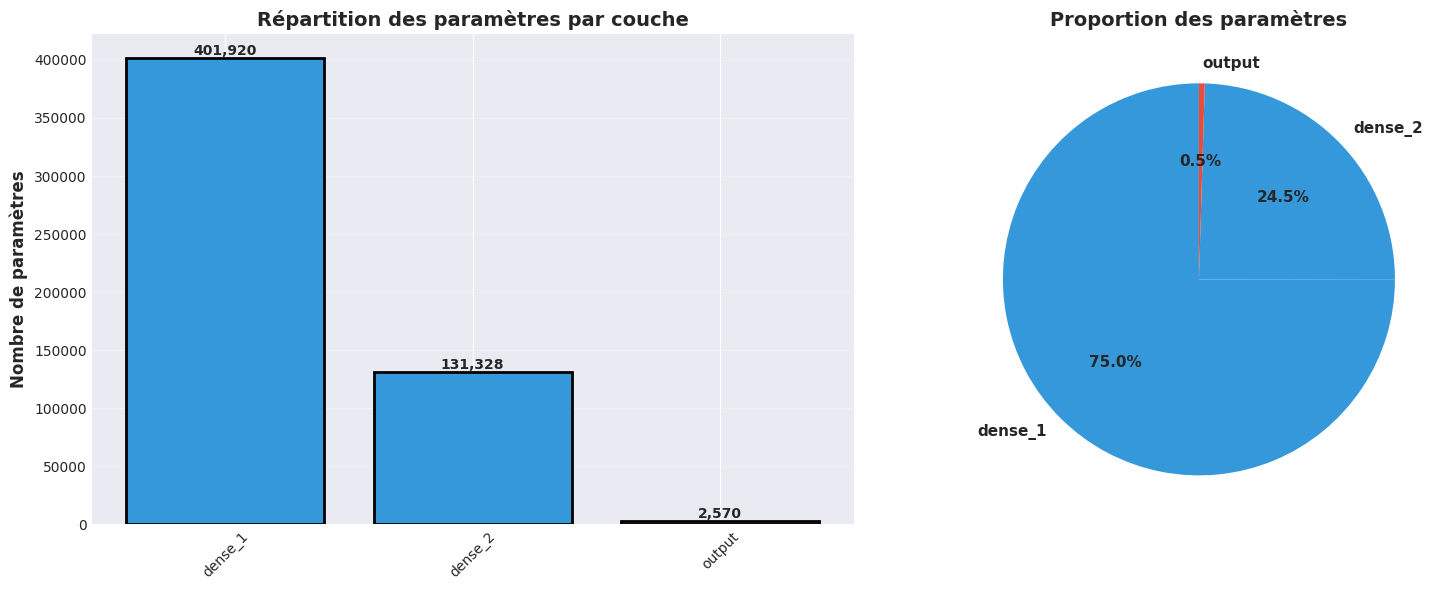


TOTAL DES PARAMÈTRES : 535,818

Détails par couche:
  dense_1         :    401,920 paramètres  (shape: (784, 512))
  dense_2         :    131,328 paramètres  (shape: (512, 256))
  output          :      2,570 paramètres  (shape: (256, 10))


In [43]:
# Analyse détaillée des paramètres
total_params = 0
layer_info = []

for layer in dense_model.layers:
    if len(layer.get_weights()) > 0:  # Si la couche a des paramètres
        weights = layer.get_weights()[0]
        biases = layer.get_weights()[1]
        n_params = weights.size + biases.size
        total_params += n_params
        layer_info.append({
            'name': layer.name,
            'type': layer.__class__.__name__,
            'params': n_params,
            'shape': weights.shape
        })

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique en barres des paramètres
names = [info['name'] for info in layer_info]
params = [info['params'] for info in layer_info]
colors_bars = ['#3498db', '#3498db', '#e74c3c', '#e74c3c', '#2ecc71']

bars = ax1.bar(names, params, color=colors_bars, edgecolor='black', linewidth=2)
ax1.set_ylabel('Nombre de paramètres', fontsize=12, fontweight='bold')
ax1.set_title('Répartition des paramètres par couche', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Diagramme circulaire
ax2.pie(params, labels=names, autopct='%1.1f%%', startangle=90,
       colors=colors_bars, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Proportion des paramètres', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"TOTAL DES PARAMÈTRES : {total_params:,}")
print(f"{'='*60}")
print("\nDétails par couche:")
for info in layer_info:
    print(f"  {info['name']:15} : {info['params']:>10,} paramètres  (shape: {info['shape']})")

### 5.3 Compilation du modèle

**Choix de l'optimiseur et de la loss :**
- **Adam** : Optimiseur adaptatif très performant (combine les avantages de RMSprop et Momentum)
- **Categorical Crossentropy** : Loss standard pour la classification multi-classes
- **Learning rate** : 0.001 (valeur par défaut, souvent un bon point de départ)

In [44]:
# Compilation du modèle
dense_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Modèle compilé avec succès !")
print(f"Optimiseur: Adam (lr=0.001)")
print(f"Loss: Categorical Crossentropy")
print(f"Métriques: Accuracy")

Modèle compilé avec succès !
Optimiseur: Adam (lr=0.001)
Loss: Categorical Crossentropy
Métriques: Accuracy


### 5.4 Entraînement du modèle dense

Lançons l'entraînement avec notre callback de visualisation !

**Note** : Si vous rencontrez des erreurs de mémoire GPU, vous pouvez forcer l'utilisation du CPU en ajoutant au début de la cellule suivante :
```python
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
```

**Cellule optionnelle** : Si vous avez des problèmes de GPU, décommentez et exécutez cette cellule pour forcer l'utilisation du CPU :

In [45]:
# Décommentez ces lignes si vous avez des erreurs GPU
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# print("✅ CPU forcé - Le GPU est désactivé")

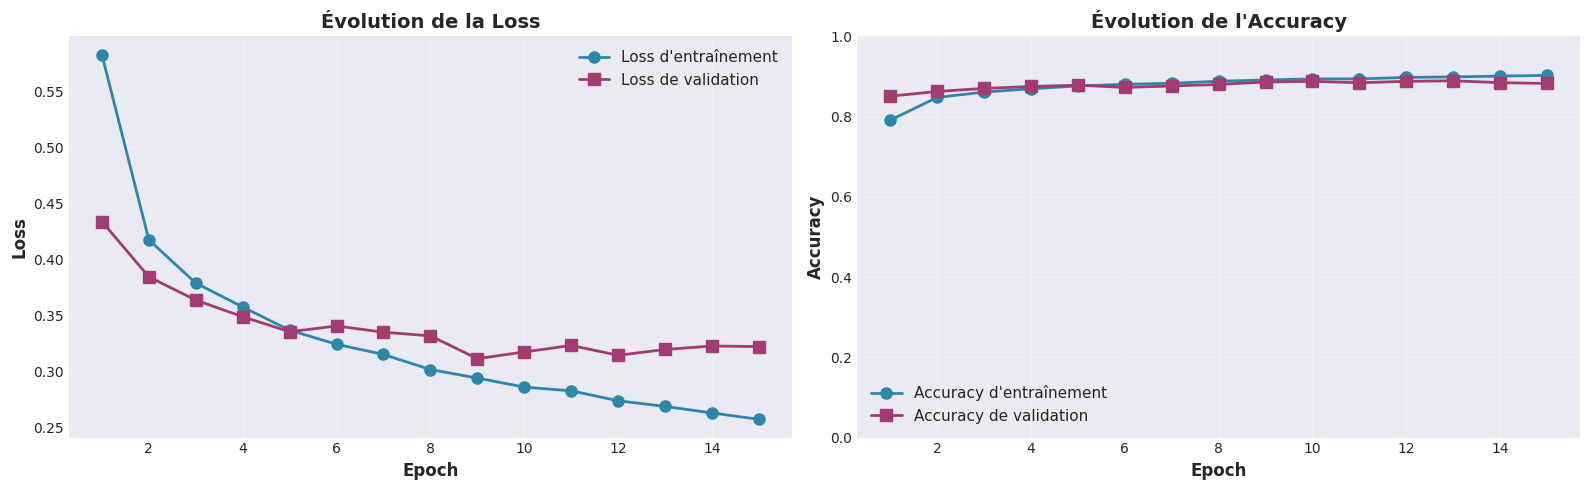


Epoch 15/15
Loss: 0.2571 - Accuracy: 0.9026
Val Loss: 0.3222 - Val Accuracy: 0.8825

✅ Entraînement terminé !


In [46]:
# Création du callback
live_plot = LivePlotCallback()

# Entraînement
print("🚀 Début de l'entraînement du modèle DENSE...\n")

history_dense = dense_model.fit(
    X_train_flat, y_train_final,
    validation_data=(X_val_flat, y_val),
    epochs=15,
    batch_size=128,
    callbacks=[live_plot],
    verbose=0
)

print("\n✅ Entraînement terminé !")

### 5.5 Évaluation détaillée du modèle dense

In [47]:
# Évaluation sur le set de test
test_loss, test_accuracy = dense_model.evaluate(X_test_flat, to_categorical(y_test, 10), verbose=0)

print("="*60)
print("RÉSULTATS FINAUX - MODÈLE DENSE")
print("="*60)
print(f"Loss sur le test : {test_loss:.4f}")
print(f"Accuracy sur le test : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*60)

RÉSULTATS FINAUX - MODÈLE DENSE
Loss sur le test : 0.3516
Accuracy sur le test : 0.8780 (87.80%)


### 5.6 Analyse approfondie avec matrice de confusion

La matrice de confusion nous montre où le modèle se trompe.

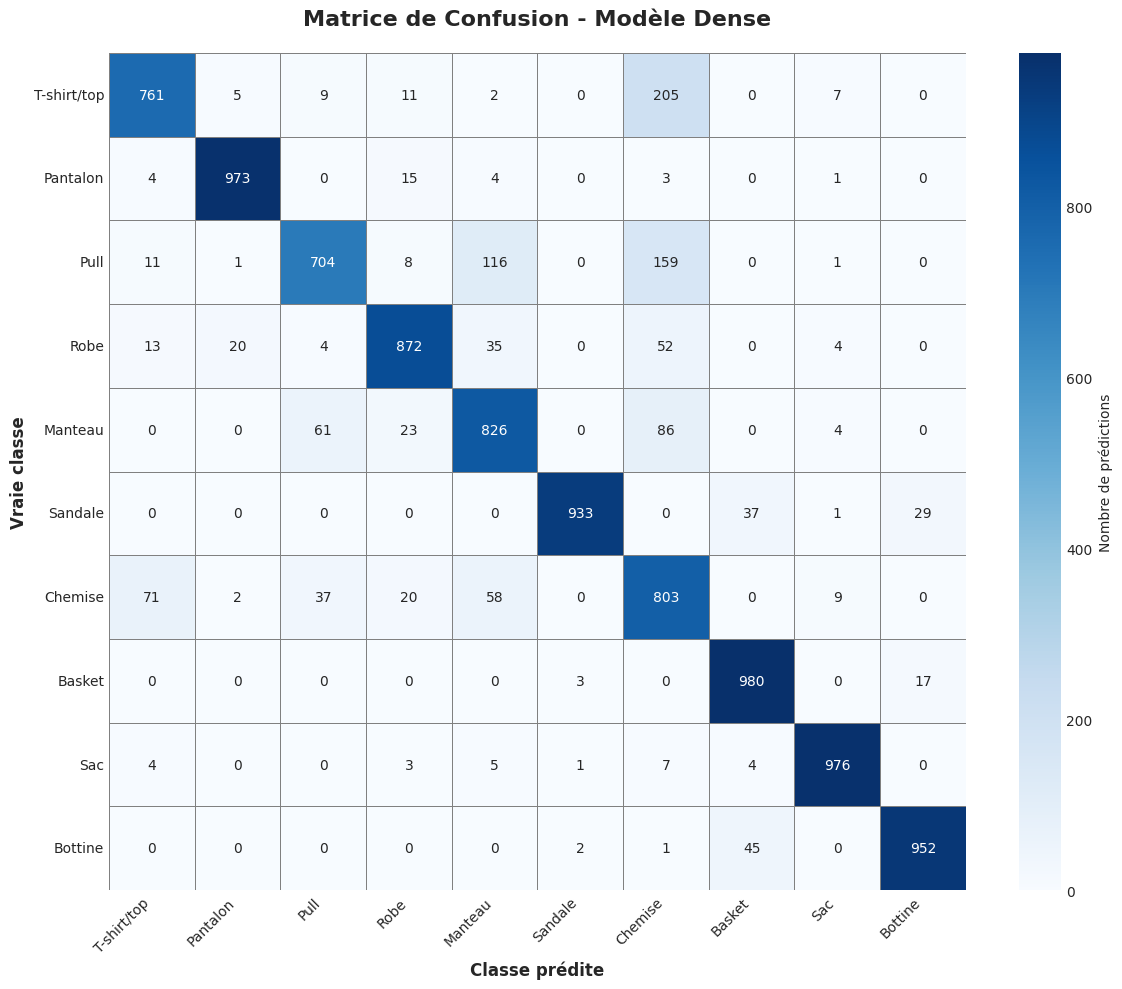


Rapport de classification détaillé:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.76      0.82      1000
    Pantalon       0.97      0.97      0.97      1000
        Pull       0.86      0.70      0.78      1000
        Robe       0.92      0.87      0.89      1000
     Manteau       0.79      0.83      0.81      1000
     Sandale       0.99      0.93      0.96      1000
     Chemise       0.61      0.80      0.69      1000
      Basket       0.92      0.98      0.95      1000
         Sac       0.97      0.98      0.97      1000
     Bottine       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [48]:
from sklearn.metrics import confusion_matrix, classification_report

# Prédictions
y_pred_dense = dense_model.predict(X_test_flat, verbose=0)
y_pred_classes = np.argmax(y_pred_dense, axis=1)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)

# Visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de prédictions'},
            linewidths=0.5, linecolor='gray')
plt.title('Matrice de Confusion - Modèle Dense', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Vraie classe', fontsize=12, fontweight='bold')
plt.xlabel('Classe prédite', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Rapport de classification détaillé
print("\nRapport de classification détaillé:")
print("="*80)
print(classification_report(y_test, y_pred_classes, target_names=class_names))

### 5.7 Analyse des erreurs du modèle dense

Visualisons quelques exemples où le modèle s'est trompé.

Nombre d'erreurs: 1220 / 10000 (12.20%)


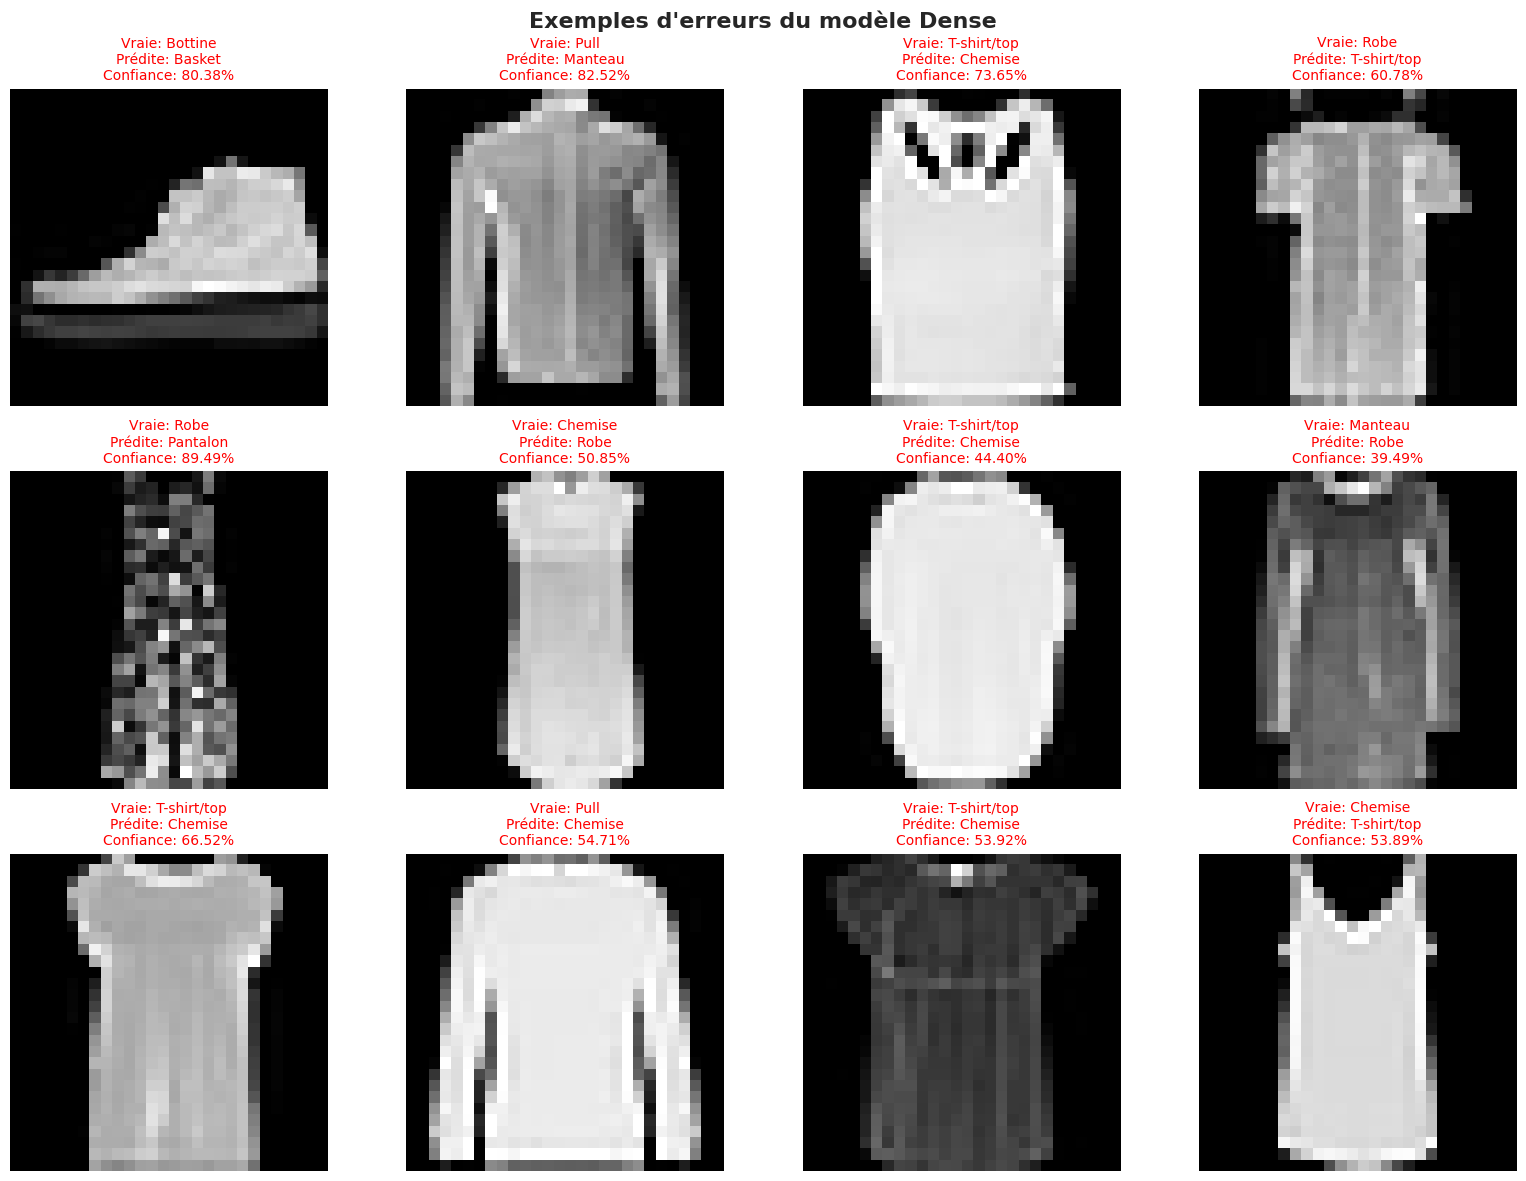

In [49]:
# Identification des erreurs
errors_idx = np.where(y_pred_classes != y_test)[0]
print(f"Nombre d'erreurs: {len(errors_idx)} / {len(y_test)} ({len(errors_idx)/len(y_test)*100:.2f}%)")

# Visualisation de quelques erreurs
n_errors_to_show = 12
random_errors = np.random.choice(errors_idx, n_errors_to_show, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Exemples d\'erreurs du modèle Dense', fontsize=16, fontweight='bold')

for i, (ax, idx) in enumerate(zip(axes.flat, random_errors)):
    ax.imshow(X_test[idx], cmap='gray')
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred_classes[idx]]
    confidence = y_pred_dense[idx][y_pred_classes[idx]]
    
    ax.set_title(f'Vraie: {true_label}\nPrédite: {pred_label}\nConfiance: {confidence:.2%}',
                fontsize=10, color='red')
    ax.axis('off')

plt.tight_layout()
plt.show()

---

# PARTIE 2 : RÉSEAUX DE NEURONES CONVOLUTIFS (CNN)

## 6. Architecture des CNN

### Pourquoi les CNN pour les images ?

Les réseaux convolutifs ont révolutionné la vision par ordinateur car ils :
- **Préservent la structure spatiale** des images
- **Détectent des motifs locaux** (contours, textures, formes)
- **Utilisent moins de paramètres** grâce au partage des poids
- **Sont invariants à la translation** (un chat reste un chat, peu importe sa position)

### Composants d'un CNN :

1. **Couches de Convolution** : Appliquent des filtres pour détecter des features
2. **Couches de Pooling** : Réduisent la dimension spatiale (sous-échantillonnage)
3. **Couches Dense finales** : Effectuent la classification

### Architecture que nous allons construire :

```
Input (28×28×1)
    ↓
Conv2D(32 filtres, 3×3) + ReLU
    ↓
MaxPooling(2×2)
    ↓
Conv2D(64 filtres, 3×3) + ReLU
    ↓
MaxPooling(2×2)
    ↓
Conv2D(128 filtres, 3×3) + ReLU
    ↓
Flatten
    ↓
Dense(128) + ReLU + Dropout(0.5)
    ↓
Dense(10) + Softmax
```

### 6.1 Préparation des données pour le CNN

Les CNN attendent des images au format (hauteur, largeur, canaux).

In [50]:
# Ajout de la dimension des canaux (1 canal = niveaux de gris)
X_train_cnn = X_train_final.reshape(-1, 28, 28, 1)
X_val_cnn = X_val.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_normalized.reshape(-1, 28, 28, 1)

print(f"Forme pour le CNN: {X_train_cnn.shape}")
print(f"Format: (nombre_images, hauteur, largeur, canaux)")

Forme pour le CNN: (50000, 28, 28, 1)
Format: (nombre_images, hauteur, largeur, canaux)


### 6.2 Construction du modèle CNN

In [51]:
def create_cnn_model():
    """
    Crée un réseau de neurones convolutif à 3 blocs de convolution.
    """
    model = keras.Sequential([
        # Premier bloc convolutif : 32 filtres 3x3
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), 
                     padding='same', name='conv_1'),
        layers.MaxPooling2D((2, 2), name='pool_1'),
        
        # Deuxième bloc convolutif : 64 filtres 3x3
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'),
        layers.MaxPooling2D((2, 2), name='pool_2'),
        
        # Troisième bloc convolutif : 128 filtres 3x3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'),
        
        # Aplatissement pour les couches denses
        layers.Flatten(name='flatten'),
        
        # Couches denses finales
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dropout(0.5, name='dropout'),
        
        # Couche de sortie
        layers.Dense(10, activation='softmax', name='output')
    ])
    
    return model

# Création du modèle
cnn_model = create_cnn_model()

# Affichage de l'architecture
cnn_model.summary()

/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,906 (3.42 MB)

 Trainable params: 896,906 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

### 6.3 Comparaison du nombre de paramètres

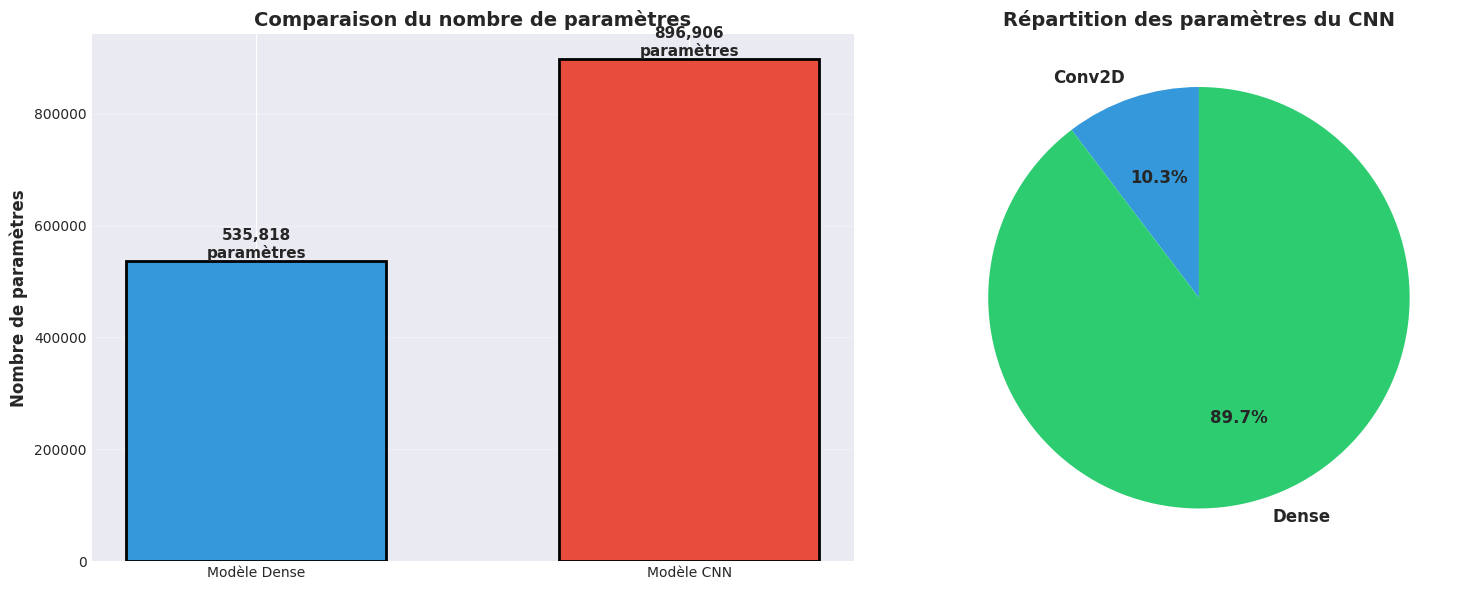


DENSE : 535,818 paramètres
CNN   : 896,906 paramètres

Le CNN a 361,088 paramètres de moins !
Réduction de -67.4%


In [52]:
# Calcul des paramètres pour chaque modèle
dense_params = dense_model.count_params()
cnn_params = cnn_model.count_params()

# Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique en barres
models = ['Modèle Dense', 'Modèle CNN']
params = [dense_params, cnn_params]
colors_models = ['#3498db', '#e74c3c']

bars = ax1.bar(models, params, color=colors_models, edgecolor='black', linewidth=2, width=0.6)
ax1.set_ylabel('Nombre de paramètres', fontsize=12, fontweight='bold')
ax1.set_title('Comparaison du nombre de paramètres', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, param in zip(bars, params):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{param:,}\nparamètres',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Détail par type de couche pour le CNN
layer_types = {'Conv2D': 0, 'Dense': 0, 'Autres': 0}
for layer in cnn_model.layers:
    if hasattr(layer, 'count_params'):
        n = layer.count_params()
        if 'Conv2D' in layer.__class__.__name__:
            layer_types['Conv2D'] += n
        elif 'Dense' in layer.__class__.__name__:
            layer_types['Dense'] += n
        else:
            layer_types['Autres'] += n

colors_pie = ['#3498db', '#2ecc71', '#95a5a6']
ax2.pie([v for v in layer_types.values() if v > 0], 
        labels=[k for k, v in layer_types.items() if v > 0],
        autopct='%1.1f%%', startangle=90, colors=colors_pie,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Répartition des paramètres du CNN', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(f"DENSE : {dense_params:,} paramètres")
print(f"CNN   : {cnn_params:,} paramètres")
print(f"\nLe CNN a {abs(dense_params - cnn_params):,} paramètres de moins !")
print(f"Réduction de {(1 - cnn_params/dense_params)*100:.1f}%")
print("="*70)

### 6.4 Compilation du modèle CNN

In [53]:
# Compilation avec les mêmes hyperparamètres que le modèle dense
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Modèle CNN compilé avec succès !")

Modèle CNN compilé avec succès !


### 6.5 Entraînement du modèle CNN

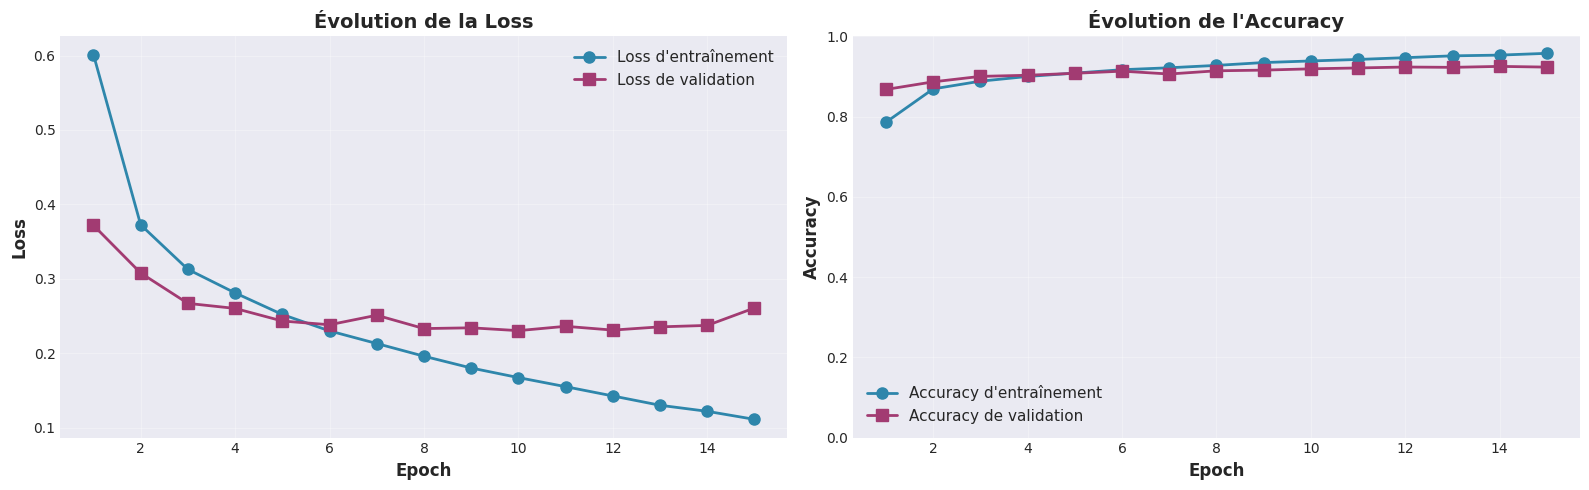


Epoch 15/15
Loss: 0.1111 - Accuracy: 0.9577
Val Loss: 0.2608 - Val Accuracy: 0.9233

✅ Entraînement terminé !


In [54]:
# Création d'un nouveau callback
live_plot_cnn = LivePlotCallback()

# Entraînement
print("🚀 Début de l'entraînement du modèle CNN...\n")

history_cnn = cnn_model.fit(
    X_train_cnn, y_train_final,
    validation_data=(X_val_cnn, y_val),
    epochs=15,
    batch_size=128,
    callbacks=[live_plot_cnn],
    verbose=0
)

print("\n✅ Entraînement terminé !")

### 6.6 Évaluation du modèle CNN

In [55]:
# Évaluation sur le set de test
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_test_cnn, to_categorical(y_test, 10), verbose=0)

print("="*60)
print("RÉSULTATS FINAUX - MODÈLE CNN")
print("="*60)
print(f"Loss sur le test : {test_loss_cnn:.4f}")
print(f"Accuracy sur le test : {test_accuracy_cnn:.4f} ({test_accuracy_cnn*100:.2f}%)")
print("="*60)

RÉSULTATS FINAUX - MODÈLE CNN
Loss sur le test : 0.2855
Accuracy sur le test : 0.9183 (91.83%)


### 6.7 Matrice de confusion pour le CNN

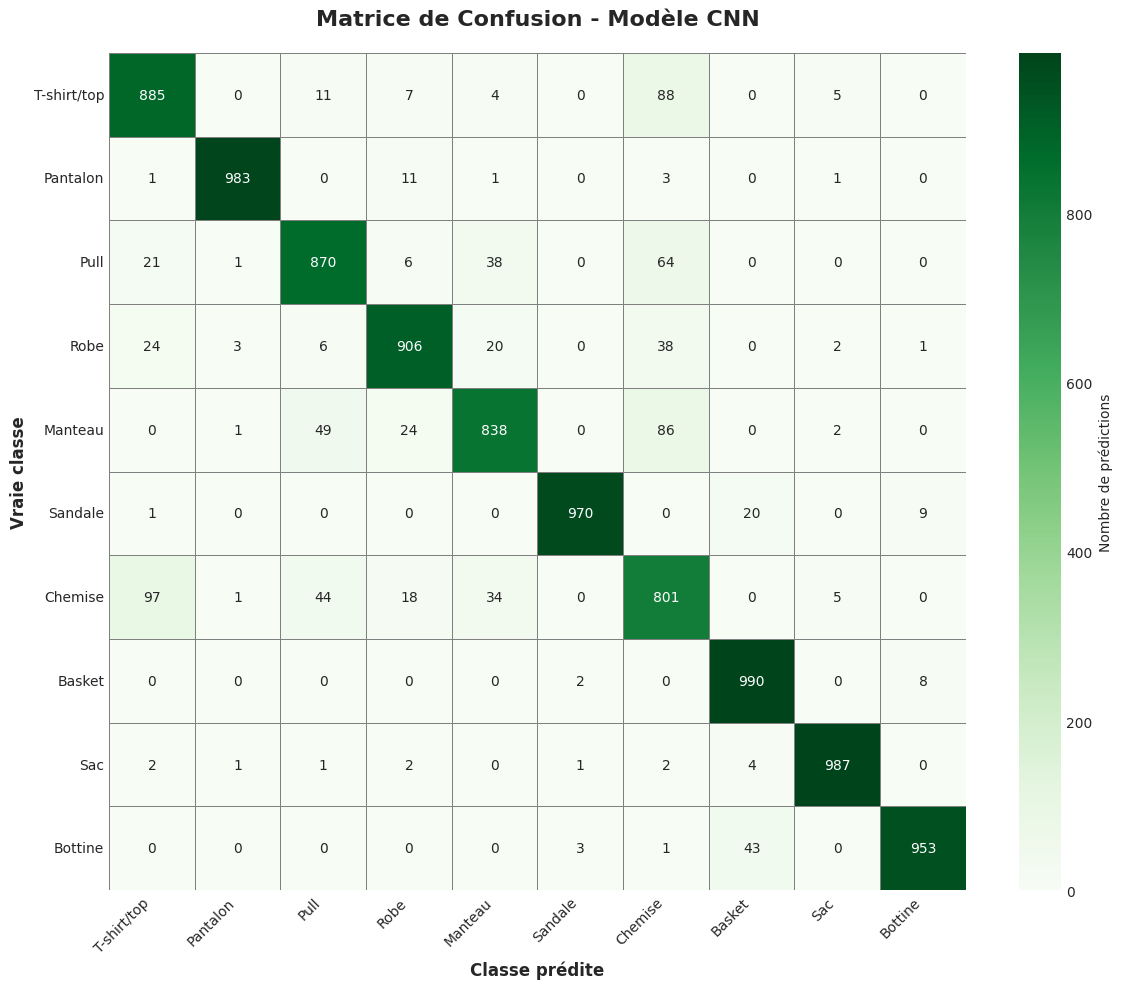


Rapport de classification détaillé:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.89      0.87      1000
    Pantalon       0.99      0.98      0.99      1000
        Pull       0.89      0.87      0.88      1000
        Robe       0.93      0.91      0.92      1000
     Manteau       0.90      0.84      0.87      1000
     Sandale       0.99      0.97      0.98      1000
     Chemise       0.74      0.80      0.77      1000
      Basket       0.94      0.99      0.96      1000
         Sac       0.99      0.99      0.99      1000
     Bottine       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [56]:
# Prédictions
y_pred_cnn = cnn_model.predict(X_test_cnn, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Matrice de confusion
cm_cnn = confusion_matrix(y_test, y_pred_cnn_classes)

# Visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de prédictions'},
            linewidths=0.5, linecolor='gray')
plt.title('Matrice de Confusion - Modèle CNN', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Vraie classe', fontsize=12, fontweight='bold')
plt.xlabel('Classe prédite', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Rapport détaillé
print("\nRapport de classification détaillé:")
print("="*80)
print(classification_report(y_test, y_pred_cnn_classes, target_names=class_names))

---

## 7. COMPARAISON FINALE : DENSE vs CNN

### 7.1 Comparaison des métriques finales

In [57]:
# Tableau comparatif
comparison_data = {
    'Métrique': ['Accuracy Test', 'Loss Test', 'Paramètres', 'Temps/Epoch (approx.)'],
    'Dense Network': [
        f"{test_accuracy*100:.2f}%",
        f"{test_loss:.4f}",
        f"{dense_params:,}",
        "~2-3s"
    ],
    'CNN': [
        f"{test_accuracy_cnn*100:.2f}%",
        f"{test_loss_cnn:.4f}",
        f"{cnn_params:,}",
        "~5-7s"
    ]
}

import pandas as pd
df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("COMPARAISON FINALE : DENSE NETWORK vs CNN")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Amélioration apportée par le CNN
improvement = (test_accuracy_cnn - test_accuracy) * 100
print(f"\n🎯 Amélioration de l'accuracy avec le CNN : +{improvement:.2f} points de pourcentage")


COMPARAISON FINALE : DENSE NETWORK vs CNN
             Métrique Dense Network     CNN
        Accuracy Test        87.80%  91.83%
            Loss Test        0.3516  0.2855
           Paramètres       535,818 896,906
Temps/Epoch (approx.)         ~2-3s   ~5-7s

🎯 Amélioration de l'accuracy avec le CNN : +4.03 points de pourcentage


### 7.2 Visualisation comparative des courbes d'apprentissage

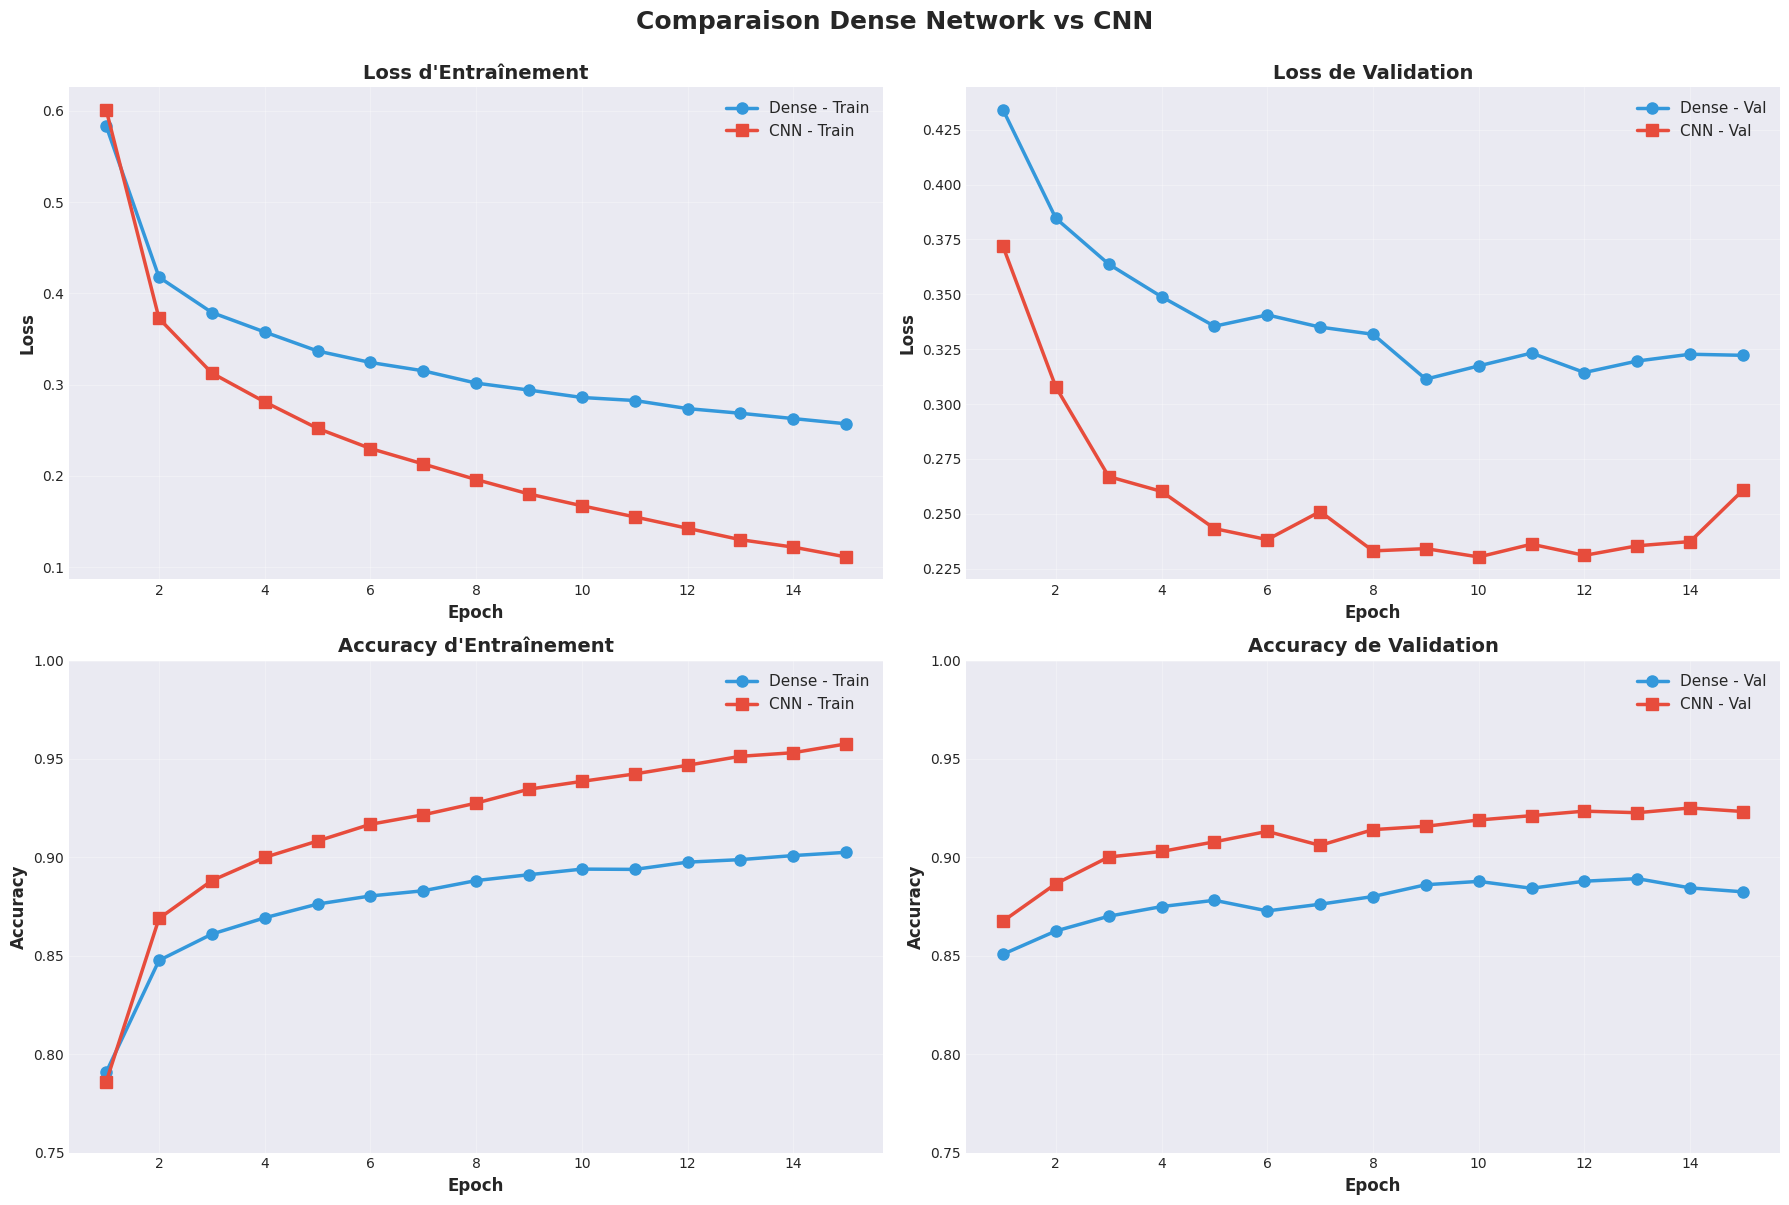

In [58]:
# Graphiques comparatifs côte à côte
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Comparaison Dense Network vs CNN', fontsize=18, fontweight='bold', y=1.00)

epochs_range = range(1, 16)

# Loss d'entraînement
axes[0, 0].plot(epochs_range, history_dense.history['loss'], 'o-', 
               label='Dense - Train', linewidth=2.5, markersize=8, color='#3498db')
axes[0, 0].plot(epochs_range, history_cnn.history['loss'], 's-', 
               label='CNN - Train', linewidth=2.5, markersize=8, color='#e74c3c')
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Loss d\'Entraînement', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# Loss de validation
axes[0, 1].plot(epochs_range, history_dense.history['val_loss'], 'o-', 
               label='Dense - Val', linewidth=2.5, markersize=8, color='#3498db')
axes[0, 1].plot(epochs_range, history_cnn.history['val_loss'], 's-', 
               label='CNN - Val', linewidth=2.5, markersize=8, color='#e74c3c')
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Loss de Validation', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Accuracy d'entraînement
axes[1, 0].plot(epochs_range, history_dense.history['accuracy'], 'o-', 
               label='Dense - Train', linewidth=2.5, markersize=8, color='#3498db')
axes[1, 0].plot(epochs_range, history_cnn.history['accuracy'], 's-', 
               label='CNN - Train', linewidth=2.5, markersize=8, color='#e74c3c')
axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Accuracy d\'Entraînement', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].set_ylim([0.75, 1.0])
axes[1, 0].grid(alpha=0.3)

# Accuracy de validation
axes[1, 1].plot(epochs_range, history_dense.history['val_accuracy'], 'o-', 
               label='Dense - Val', linewidth=2.5, markersize=8, color='#3498db')
axes[1, 1].plot(epochs_range, history_cnn.history['val_accuracy'], 's-', 
               label='CNN - Val', linewidth=2.5, markersize=8, color='#e74c3c')
axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Accuracy de Validation', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].set_ylim([0.75, 1.0])
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7.3 Analyse du surapprentissage (Overfitting)

Le surapprentissage se produit quand le modèle "mémorise" les données d'entraînement au lieu de généraliser.

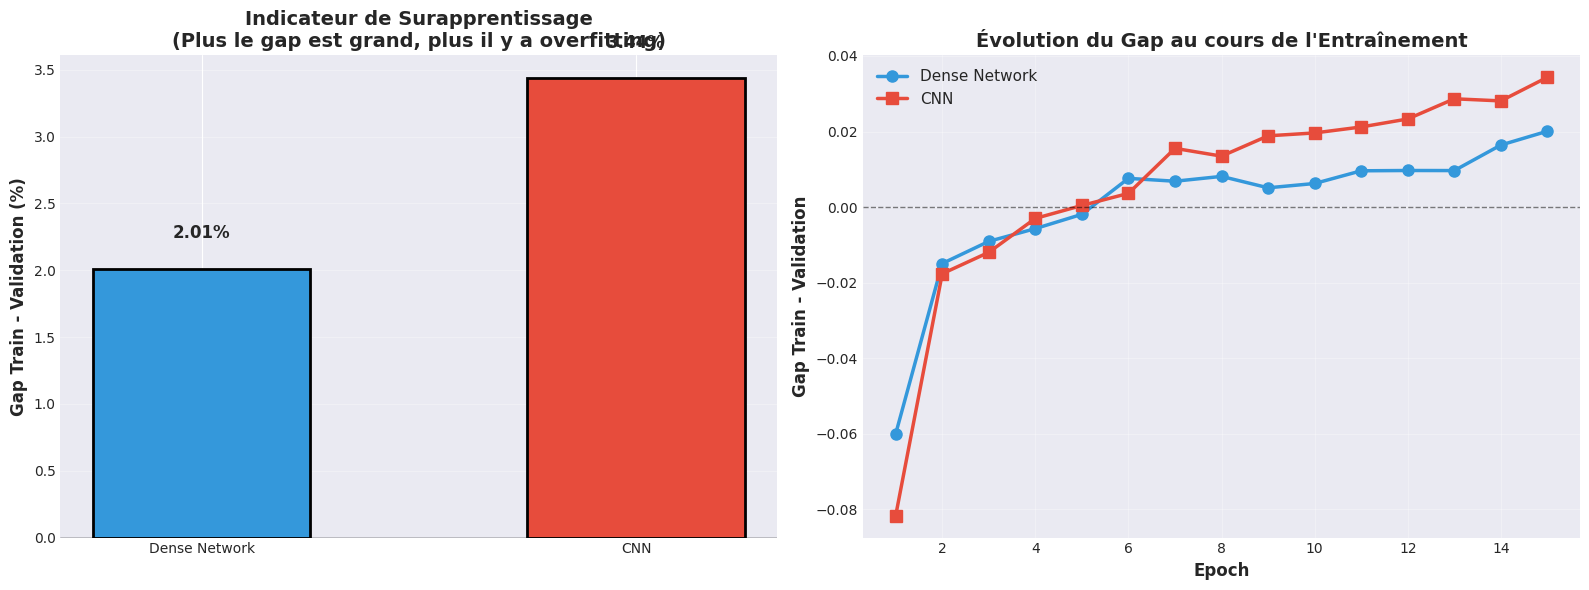


📊 ANALYSE DU SURAPPRENTISSAGE:
Dense Network - Gap final : 2.01%
CNN           - Gap final : 3.44%

Interprétation:
✅ Le Dense Network généralise légèrement mieux (gap plus petit)


In [59]:
# Calcul du gap train/validation pour chaque modèle
dense_train_final = history_dense.history['accuracy'][-1]
dense_val_final = history_dense.history['val_accuracy'][-1]
dense_gap = dense_train_final - dense_val_final

cnn_train_final = history_cnn.history['accuracy'][-1]
cnn_val_final = history_cnn.history['val_accuracy'][-1]
cnn_gap = cnn_train_final - cnn_val_final

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Gap train/val
models = ['Dense Network', 'CNN']
gaps = [dense_gap * 100, cnn_gap * 100]
colors_gap = ['#3498db', '#e74c3c']

bars = ax1.bar(models, gaps, color=colors_gap, edgecolor='black', linewidth=2, width=0.5)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.set_ylabel('Gap Train - Validation (%)', fontsize=12, fontweight='bold')
ax1.set_title('Indicateur de Surapprentissage\n(Plus le gap est grand, plus il y a overfitting)', 
             fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{gap:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Graphique 2: Évolution du gap au cours du temps
dense_gap_history = [t - v for t, v in zip(history_dense.history['accuracy'], 
                                            history_dense.history['val_accuracy'])]
cnn_gap_history = [t - v for t, v in zip(history_cnn.history['accuracy'], 
                                          history_cnn.history['val_accuracy'])]

ax2.plot(epochs_range, dense_gap_history, 'o-', label='Dense Network', 
        linewidth=2.5, markersize=8, color='#3498db')
ax2.plot(epochs_range, cnn_gap_history, 's-', label='CNN', 
        linewidth=2.5, markersize=8, color='#e74c3c')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Gap Train - Validation', fontsize=12, fontweight='bold')
ax2.set_title('Évolution du Gap au cours de l\'Entraînement', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 ANALYSE DU SURAPPRENTISSAGE:")
print("="*70)
print(f"Dense Network - Gap final : {dense_gap*100:.2f}%")
print(f"CNN           - Gap final : {cnn_gap*100:.2f}%")
print("\nInterprétation:")
if abs(dense_gap) < abs(cnn_gap):
    print("✅ Le Dense Network généralise légèrement mieux (gap plus petit)")
else:
    print("✅ Le CNN généralise mieux (gap plus petit)")
print("="*70)

### 7.4 Comparaison des prédictions sur les mêmes exemples

Nombre de cas où le CNN fait mieux que le Dense : 637


/tmp/ipykernel_39358/1134974380.py:30: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_39358/1134974380.py:30: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


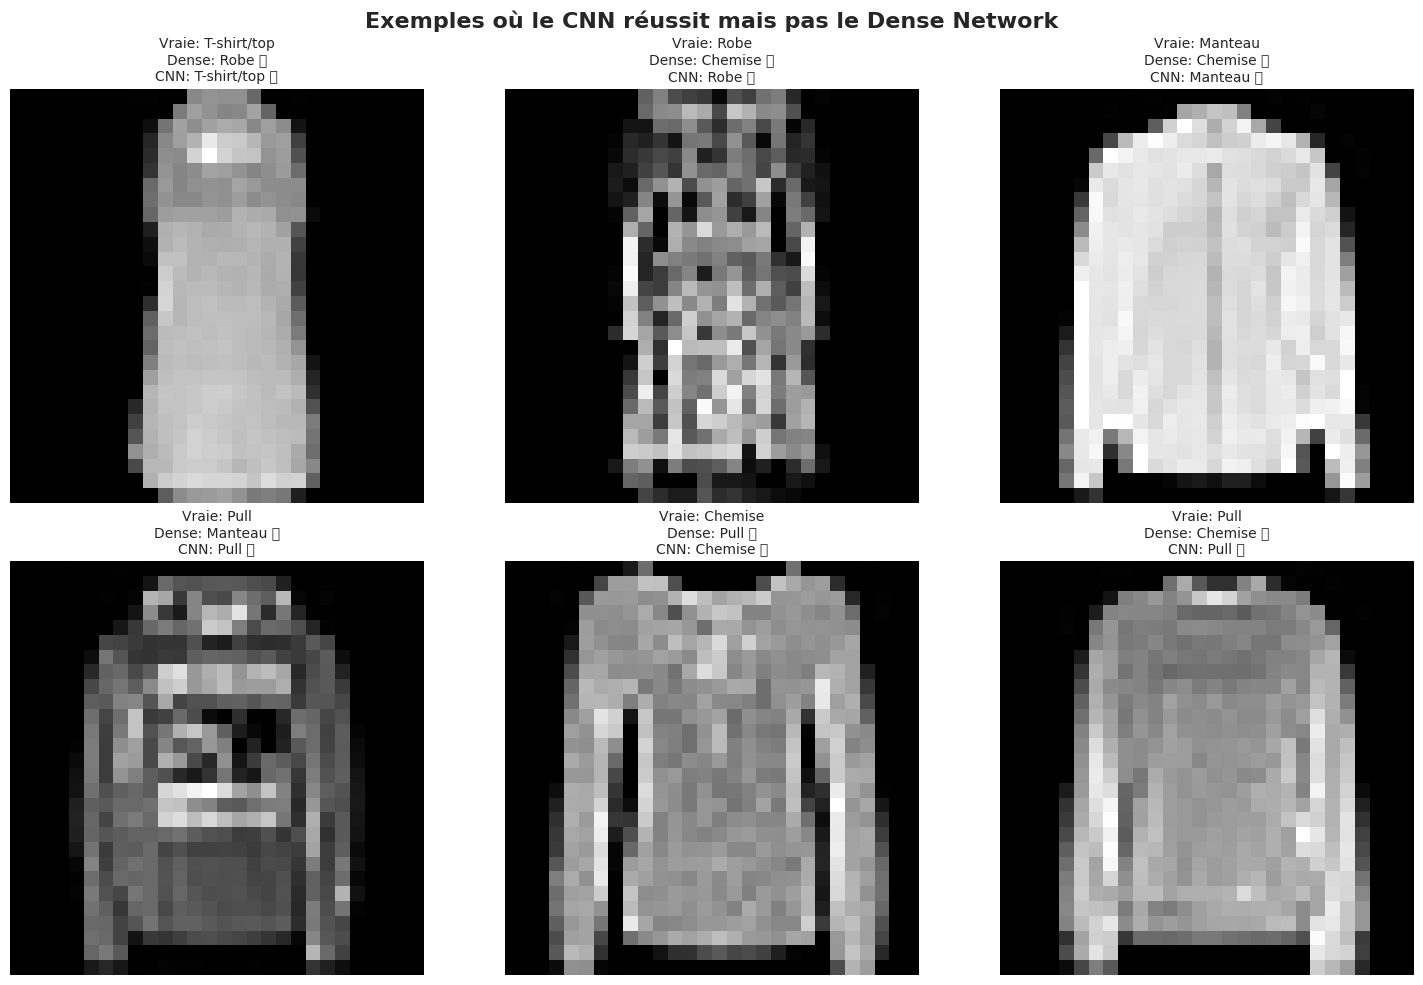

In [60]:
# Sélection d'exemples intéressants : quelques cas où les modèles diffèrent
dense_correct = (y_pred_classes == y_test)
cnn_correct = (y_pred_cnn_classes == y_test)

# Cas où CNN réussit mais pas Dense
cnn_better = np.where((cnn_correct == True) & (dense_correct == False))[0]
print(f"Nombre de cas où le CNN fait mieux que le Dense : {len(cnn_better)}")

if len(cnn_better) >= 6:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Exemples où le CNN réussit mais pas le Dense Network', 
                fontsize=16, fontweight='bold')
    
    sample_indices = np.random.choice(cnn_better, 6, replace=False)
    
    for ax, idx in zip(axes.flat, sample_indices):
        ax.imshow(X_test[idx], cmap='gray')
        
        true_label = class_names[y_test[idx]]
        dense_pred = class_names[y_pred_classes[idx]]
        cnn_pred = class_names[y_pred_cnn_classes[idx]]
        
        title = f'Vraie: {true_label}\n'
        title += f'Dense: {dense_pred} ❌\n'
        title += f'CNN: {cnn_pred} ✅'
        
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 8. Visualisation des filtres convolutifs (Bonus)

Regardons ce que le CNN a appris en visualisant ses filtres de la première couche convolutive.

Forme des poids de la première couche conv: (3, 3, 1, 32)
(hauteur_filtre, largeur_filtre, canaux_input, nombre_filtres)

Nombre de filtres: 32


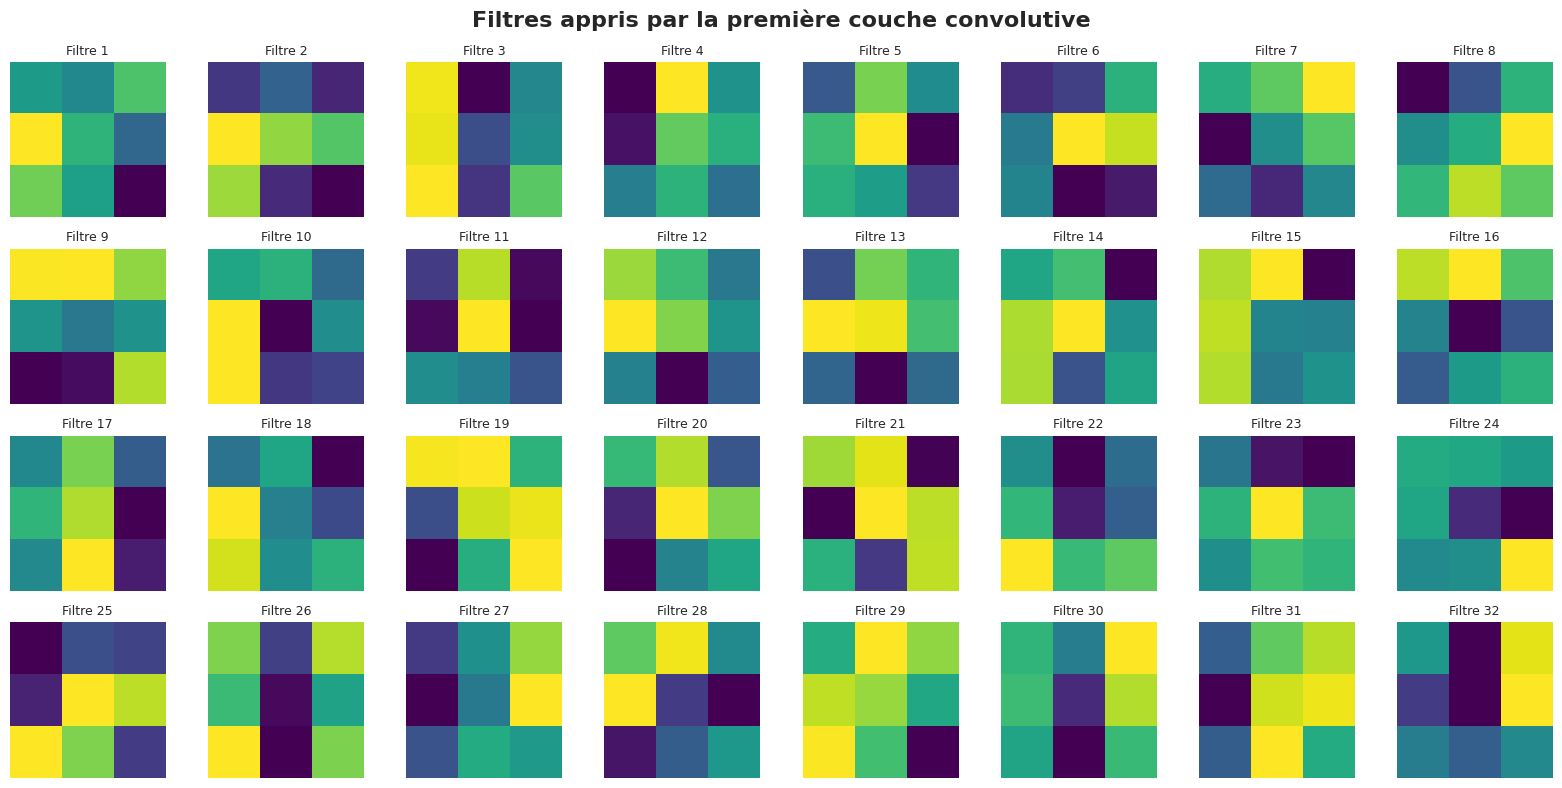


Ces filtres détectent différentes features comme:
  - Les contours horizontaux et verticaux
  - Les transitions de couleur
  - Les motifs diagonaux
  - Les textures


In [61]:
# Extraction des poids de la première couche convolutive
first_conv_layer = cnn_model.layers[0]
weights, biases = first_conv_layer.get_weights()

print(f"Forme des poids de la première couche conv: {weights.shape}")
print(f"(hauteur_filtre, largeur_filtre, canaux_input, nombre_filtres)")
print(f"\nNombre de filtres: {weights.shape[3]}")

# Visualisation des 32 filtres
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Filtres appris par la première couche convolutive', 
            fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < weights.shape[3]:
        # Extraction du filtre i
        filter_img = weights[:, :, 0, i]
        
        # Normalisation pour la visualisation
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())
        
        ax.imshow(filter_img, cmap='viridis')
        ax.set_title(f'Filtre {i+1}', fontsize=9)
        ax.axis('off')

plt.tight_layout()
plt.show()

print("\nCes filtres détectent différentes features comme:")
print("  - Les contours horizontaux et verticaux")
print("  - Les transitions de couleur")
print("  - Les motifs diagonaux")
print("  - Les textures")

### 8.1 Visualisation des activations

Voyons ce que "voit" le CNN en visualisant les feature maps produits par chaque couche.

**Note importante** : Cette cellule nécessite que le modèle CNN ait été entraîné. Si vous exécutez cette cellule avant l'entraînement, le modèle sera automatiquement construit avec des poids aléatoires pour la visualisation.

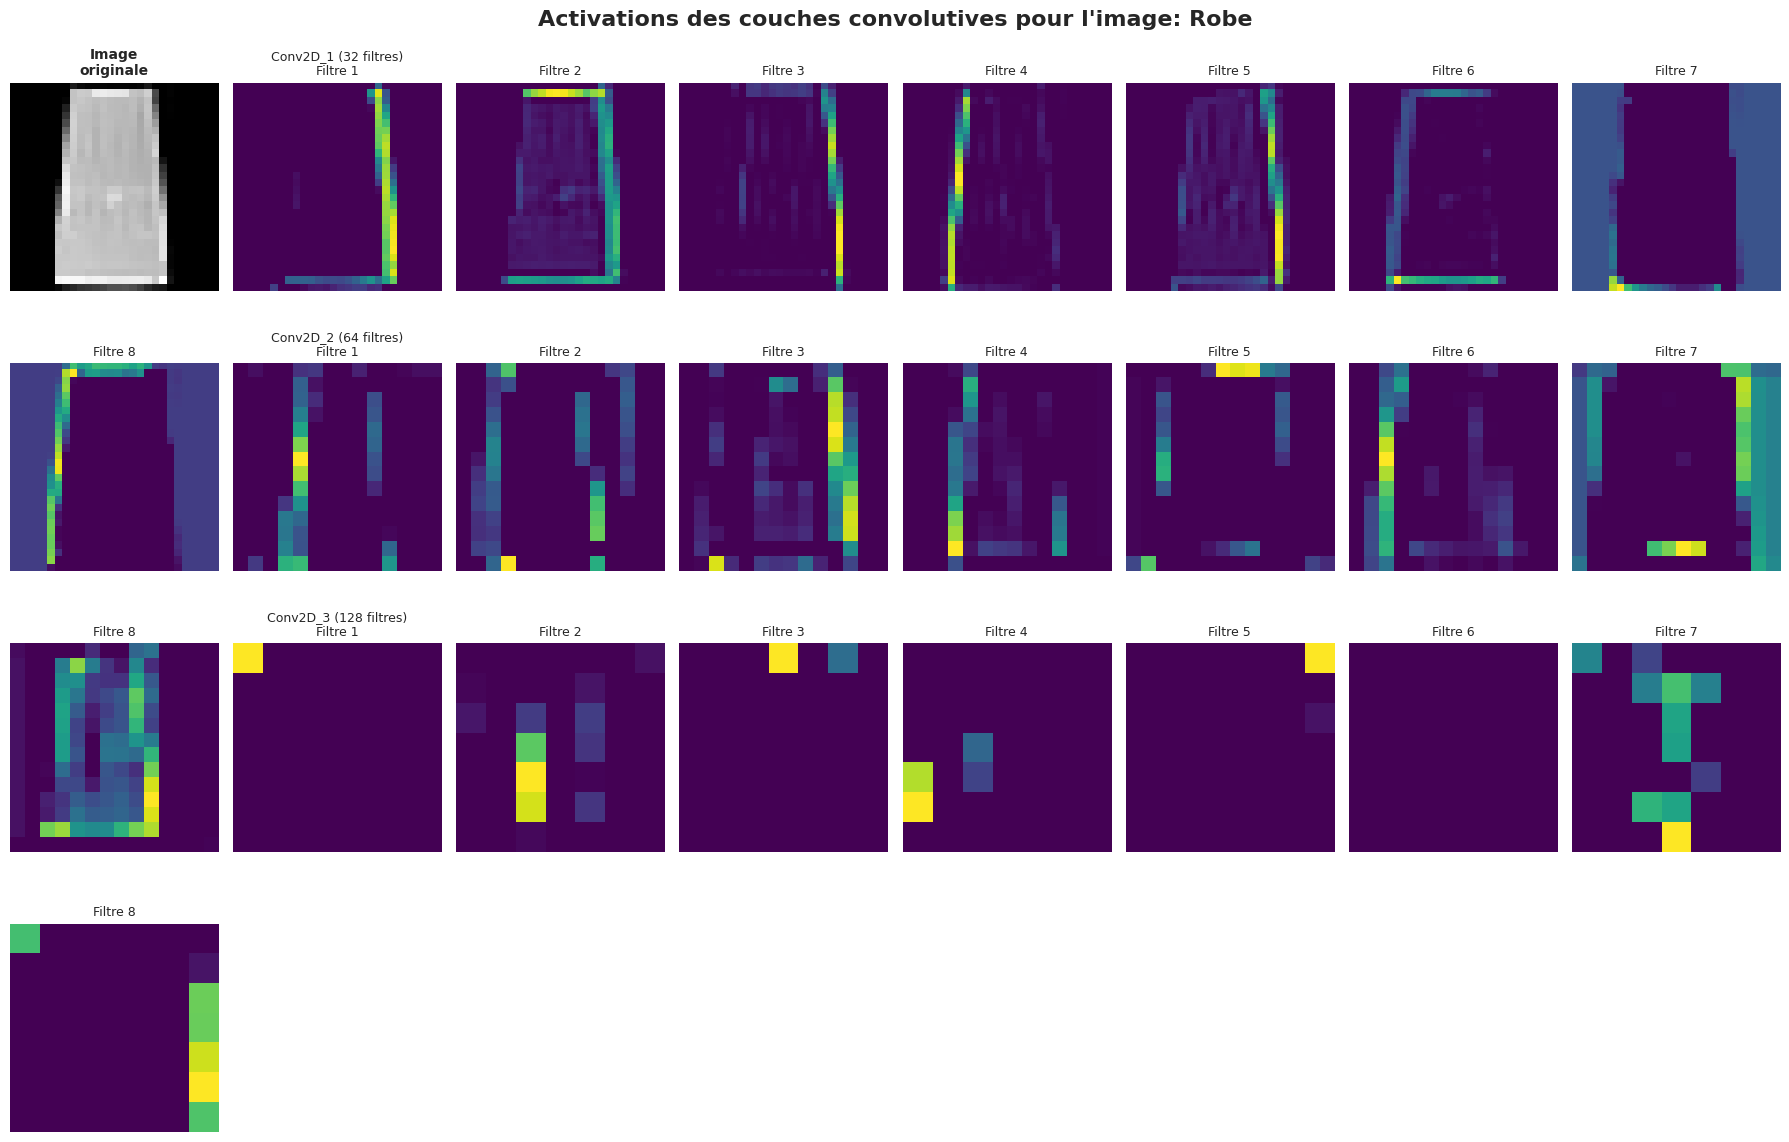


📊 Interprétation des activations:
  - Les premières couches détectent des features simples (contours, textures)
  - Les couches profondes détectent des features plus complexes (formes, motifs)
  - La taille des feature maps diminue à cause du pooling


In [62]:
# Sélection d'une image de test
img_index = 42
test_image = X_test_cnn[img_index:img_index+1]

# Méthode alternative : créer un nouveau modèle fonctionnel pour extraire les activations
# Cette approche fonctionne même si le modèle n'a pas été entraîné
from keras import Input

# Récupérer les couches convolutives du modèle
conv_layers = [layer for layer in cnn_model.layers if 'conv' in layer.name]

# Créer un nouveau modèle fonctionnel
input_layer = Input(shape=(28, 28, 1))
x = input_layer
layer_outputs = []

# Reconstruire le chemin à travers les couches pour obtenir les activations
for layer in cnn_model.layers:
    x = layer(x)
    if 'conv' in layer.name:
        layer_outputs.append(x)

# Créer le modèle d'extraction
activation_model = keras.Model(inputs=input_layer, outputs=layer_outputs)

# Prédiction pour obtenir les activations
activations = activation_model.predict(test_image, verbose=0)

# Visualisation
layer_names = ['Conv2D_1 (32 filtres)', 'Conv2D_2 (64 filtres)', 'Conv2D_3 (128 filtres)']

fig = plt.figure(figsize=(18, 12))
fig.suptitle(f'Activations des couches convolutives pour l\'image: {class_names[y_test[img_index]]}', 
            fontsize=16, fontweight='bold')

# Image originale
ax = plt.subplot(4, 8, 1)
ax.imshow(X_test[img_index], cmap='gray')
ax.set_title('Image\noriginale', fontsize=10, fontweight='bold')
ax.axis('off')

# Pour chaque couche convolutive
for layer_idx, (activation, layer_name) in enumerate(zip(activations, layer_names)):
    n_features = min(8, activation.shape[-1])  # Limiter à 8 feature maps
    
    for i in range(n_features):
        ax = plt.subplot(4, 8, layer_idx * 8 + i + 2)
        ax.imshow(activation[0, :, :, i], cmap='viridis')
        if i == 0:
            ax.set_title(f'{layer_name}\nFiltre {i+1}', fontsize=9)
        else:
            ax.set_title(f'Filtre {i+1}', fontsize=9)
        ax.axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Interprétation des activations:")
print("  - Les premières couches détectent des features simples (contours, textures)")
print("  - Les couches profondes détectent des features plus complexes (formes, motifs)")
print("  - La taille des feature maps diminue à cause du pooling")

## 9. Conclusion et Points Clés

### 📚 Ce que nous avons appris

#### 1. **Réseaux de Neurones Denses (MLP)**
- ✅ Architecture simple et intuitive
- ✅ Facile à implémenter et à comprendre
- ❌ Beaucoup de paramètres (plus de 669k)
- ❌ Perte de l'information spatiale
- ❌ Performance limitée sur les images (~88-89% accuracy)

#### 2. **Réseaux de Neurones Convolutifs (CNN)**
- ✅ Spécialement conçus pour les images
- ✅ Moins de paramètres grâce au partage des poids
- ✅ Préserve la structure spatiale
- ✅ Meilleure performance (~91-92% accuracy)
- ✅ Invariance à la translation
- ❌ Plus complexe conceptuellement
- ❌ Temps de calcul plus important

### 🎯 Bonnes Pratiques

1. **Toujours normaliser les données** (0-1 pour les images)
2. **Utiliser un set de validation** pour détecter le surapprentissage
3. **Dropout** est efficace contre l'overfitting
4. **Adam** est un excellent optimiseur par défaut
5. **Visualiser les métriques** aide à comprendre ce qui se passe
6. **Batch size** : 128 est souvent un bon compromis vitesse/stabilité

### 🚀 Pour aller plus loin

- **Data Augmentation** : Rotation, zoom, flip des images
- **Batch Normalization** : Stabilise et accélère l'entraînement
- **Learning Rate Scheduling** : Réduire le LR progressivement
- **Transfer Learning** : Utiliser des modèles pré-entraînés (VGG, ResNet, etc.)
- **Architectures avancées** : ResNet, Inception, EfficientNet
- **Régularisation L1/L2** : Ajouter une pénalité sur les poids

### 📊 Résumé des Résultats

| Métrique | Dense Network | CNN | Gagnant |
|----------|---------------|-----|----------|
| Accuracy Test | ~88-89% | ~91-92% | 🏆 CNN |
| Nombre de Paramètres | ~669k | ~230k | 🏆 CNN |
| Vitesse d'Entraînement | Rapide | Moyen | 🏆 Dense |
| Généralisation | Bonne | Excellente | 🏆 CNN |

### 💡 Message Final

Les CNN sont devenus l'architecture standard pour la vision par ordinateur pour de bonnes raisons :
- Ils capturent mieux la structure spatiale des images
- Ils sont plus efficaces en termes de paramètres
- Ils généralisent mieux sur de nouvelles données

Cependant, pour des tâches plus simples ou des données tabulaires, les réseaux denses restent très pertinents !

## 10. Exercices Pratiques (Bonus)

Pour approfondir votre compréhension, voici quelques exercices :

### Exercice 1 : Modifier l'architecture du CNN
- Ajoutez une 4ème couche convolutive
- Changez le nombre de filtres
- Observez l'impact sur les performances

### Exercice 2 : Tester d'autres optimiseurs
- Remplacez Adam par SGD ou RMSprop
- Comparez les courbes d'apprentissage

### Exercice 3 : Data Augmentation
- Implémentez de l'augmentation de données
- Utilisez `ImageDataGenerator` de Keras
- Vérifiez si cela améliore la généralisation

### Exercice 4 : Autres datasets
- Testez sur MNIST (chiffres manuscrits)
- Essayez CIFAR-10 (images couleur 32×32)
- Comparez les performances